# Supervised Learning on MNIST with Perceptron and Delta Rule  

In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

def mnist_to_numpy(dataset):
    X = dataset.data.numpy().astype(np.float32) / 255.0
    X = X.reshape(len(dataset), -1)
    y = dataset.targets.numpy().astype(np.int64)
    return X, y

X_train, y_train = mnist_to_numpy(train_dataset)
X_test,  y_test  = mnist_to_numpy(test_dataset)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (60000, 784)
y_train shape: (60000,)


## Perceptron: Binary Classification

Perceptron rule described in Chapter 8.4

- Inputs: $u \in \mathbb{R}^{784}$
- Output: $v \in \{+1, -1\}$
- Label: $y \in \{+1, -1\}$
- Activation:
  $$
  v = \text{sign}(w \cdot u - \gamma)
  $$
- Update rule (error-correcting):
  - If $v \neq y$, then
    $$
    w \leftarrow w + \eta \, y \, u
    $$
  - Otherwise, no change.

In [ ]:
target_digit = 3

# Labels: +1 for target_digit, -1 otherwise
y_train_bin = np.where(y_train == target_digit, 1, -1)
y_test_bin  = np.where(y_test == target_digit, 1, -1)

print("Positive class (digit):", target_digit)
print("Training positives:", np.sum(y_train_bin == 1))
print("Training negatives:", np.sum(y_train_bin == -1))


Positive class (digit): 3
Training positives: 6131
Training negatives: 53869


In [ ]:
def perceptron_train(X, y, epochs=5, eta=1.0, bias=True):
    """
    X: (N, D) numpy array
    y: (N,) labels in {+1, -1}
    """
    N, D = X.shape
    w = np.zeros(D, dtype=np.float32)
    b = 0.0 if bias else None

    for epoch in range(epochs):
        # Shuffle data each epoch
        idx = np.random.permutation(N)
        X_shuffled = X[idx]
        y_shuffled = y[idx]

        mistakes = 0
        for u, label in zip(X_shuffled, y_shuffled):
            activation = np.dot(w, u) + (b if b is not None else 0.0)
            v = 1 if activation >= 0 else -1
            if v != label:
                # Perceptron update
                w += eta * label * u
                if b is not None:
                    b += eta * label
                mistakes += 1

        print(f"Epoch {epoch+1}/{epochs} - mistakes: {mistakes} / {N}")

    return w, b

def perceptron_predict(X, w, b=None):
    activation = X @ w + (b if b is not None else 0.0)
    return np.where(activation >= 0, 1, -1)


In [6]:

# Train and evaluate the perceptron on the binary task

w_p, b_p = perceptron_train(X_train, y_train_bin, epochs=5, eta=1.0, bias=True)

y_pred_train = perceptron_predict(X_train, w_p, b_p)
y_pred_test  = perceptron_predict(X_test,  w_p, b_p)

train_acc = np.mean(y_pred_train == y_train_bin)
test_acc  = np.mean(y_pred_test  == y_test_bin)

print(f"Perceptron (digit {target_digit} vs not):")
print(f"  Train accuracy: {train_acc:.4f}")
print(f"  Test  accuracy: {test_acc:.4f}")


Epoch 1/5 - mistakes: 2799 / 60000
Epoch 2/5 - mistakes: 2478 / 60000
Epoch 3/5 - mistakes: 2488 / 60000
Epoch 4/5 - mistakes: 2443 / 60000
Epoch 5/5 - mistakes: 2397 / 60000
Perceptron (digit 3 vs not):
  Train accuracy: 0.9646
  Test  accuracy: 0.9641


## Delta Rule: Multiclass Linear Classifier (10 digits)

Now we implement the **delta rule** (gradient descent on squared error) for a 10-way classifier.

- Inputs: \( u \in \mathbb{R}^{784} \)
- Weights: \( W \in \mathbb{R}^{10 \times 784} \), biases \( b \in \mathbb{R}^{10} \)
- Output (linear):
  \[
  v = W u + b
  \]
- Targets: one-hot vectors \( t \in \mathbb{R}^{10} \)
- Error:
  \[
  E = \frac{1}{2} \| v - t \|^2
  \]
- Delta rule (for one mini-batch):
  \[
  \Delta W = \eta (t - v) u^T, \quad \Delta b = \eta (t - v)
  \]

We apply this with mini-batches for efficiency.

In [7]:

# Prepare one-hot targets for multiclass delta rule

num_classes = 10

def one_hot(labels, num_classes=10):
    N = labels.shape[0]
    T = np.zeros((N, num_classes), dtype=np.float32)
    T[np.arange(N), labels] = 1.0
    return T

T_train = one_hot(y_train, num_classes=num_classes)
T_test  = one_hot(y_test,  num_classes=num_classes)

print("T_train shape:", T_train.shape)


T_train shape: (60000, 10)


In [8]:

# Delta rule training (mini-batch version)

def delta_rule_train(X, T, epochs=10, eta=0.01, batch_size=128, weight_decay=0.0):
    """
    X: (N, D), input vectors
    T: (N, C), one-hot targets
    """
    N, D = X.shape
    _, C = T.shape

    W = np.zeros((C, D), dtype=np.float32)
    b = np.zeros(C, dtype=np.float32)

    num_batches = int(np.ceil(N / batch_size))

    for epoch in range(epochs):
        idx = np.random.permutation(N)
        X_shuffled = X[idx]
        T_shuffled = T[idx]

        epoch_loss = 0.0

        for i in range(num_batches):
            start = i * batch_size
            end   = min((i + 1) * batch_size, N)

            Xb = X_shuffled[start:end]        # (B, D)
            Tb = T_shuffled[start:end]        # (B, C)

            # Forward: linear output
            Vb = Xb @ W.T + b                 # (B, C)

            # Error (B, C)
            Eb = Tb - Vb

            # Gradient step (delta rule)
            dW = (Eb.T @ Xb) / Xb.shape[0]    # (C, D)
            db = Eb.mean(axis=0)              # (C,)

            # Optional weight decay (like supervised Hebbian with decay)
            W += eta * (dW - weight_decay * W)
            b += eta * db

            batch_loss = 0.5 * np.mean((Vb - Tb) ** 2)
            epoch_loss += batch_loss

        epoch_loss /= num_batches
        print(f"Epoch {epoch+1}/{epochs} - MSE: {epoch_loss:.4f}")

    return W, b

def delta_rule_predict(X, W, b):
    # Linear scores
    V = X @ W.T + b
    # Predict class by argmax of score
    return np.argmax(V, axis=1)


In [9]:

# Train and evaluate the delta-rule model on full 10-way MNIST

W_d, b_d = delta_rule_train(
    X_train, T_train,
    epochs=10,
    eta=0.01,
    batch_size=256,
    weight_decay=1e-4  # small decay for stability
)

y_pred_train_multi = delta_rule_predict(X_train, W_d, b_d)
y_pred_test_multi  = delta_rule_predict(X_test,  W_d, b_d)

train_acc_multi = np.mean(y_pred_train_multi == y_train)
test_acc_multi  = np.mean(y_pred_test_multi  == y_test)

print("Delta-rule linear classifier (10-way):")
print(f"  Train accuracy: {train_acc_multi:.4f}")
print(f"  Test  accuracy: {test_acc_multi:.4f}")


Epoch 1/10 - MSE: 0.0259
Epoch 2/10 - MSE: 0.0218
Epoch 3/10 - MSE: 0.0211
Epoch 4/10 - MSE: 0.0207
Epoch 5/10 - MSE: 0.0205
Epoch 6/10 - MSE: 0.0203
Epoch 7/10 - MSE: 0.0202
Epoch 8/10 - MSE: 0.0201
Epoch 9/10 - MSE: 0.0200
Epoch 10/10 - MSE: 0.0199
Delta-rule linear classifier (10-way):
  Train accuracy: 0.8545
  Test  accuracy: 0.8603


## Visualizing Learned Weights

For the multiclass delta-rule model, each row of \( W \) corresponds to a digit class.
We can visualize these rows as 28×28 images to see what pattern each class has learned.

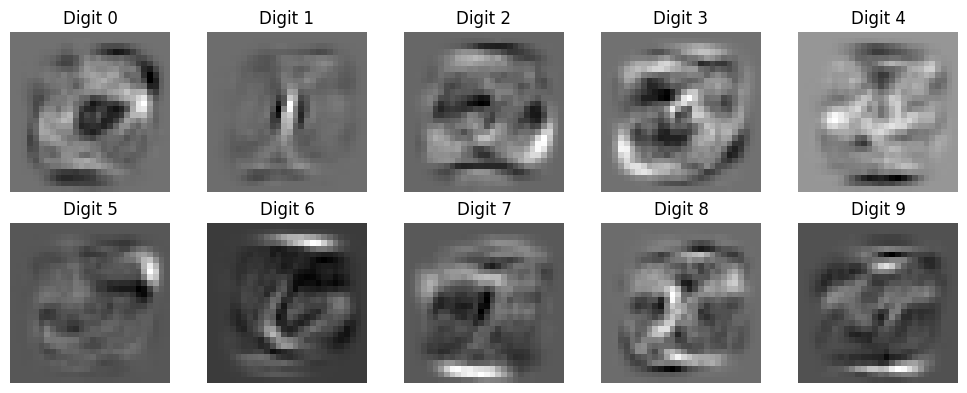

In [10]:

# Visualize weight "templates" learned by delta rule

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

for c in range(num_classes):
    w_img = W_d[c].reshape(28, 28)
    axes[c].imshow(w_img, cmap="gray")
    axes[c].set_title(f"Digit {c}")
    axes[c].axis("off")

plt.tight_layout()
plt.show()


## Summary

- Implemented a **perceptron** for binary classification using the error-correcting rule:
  \[
  w \leftarrow w + \eta \, y \, u
  \]
  whenever the output \( v \) disagreed with the label \( y \).

- Implemented a **multiclass linear model** trained by the **delta rule**:
  \[
  \Delta W = \eta (t - v) u^T, \quad \Delta b = \eta (t - v)
  \]
  minimizing squared error between outputs and one-hot targets.

- Both models are **single-layer**, consistent with the supervised learning formalism of Chapter 8.4:
  - No hidden layers.
  - No backpropagation through depth.
  - Learning is driven by local (or effectively local) error signals.